In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-with-disaster-tweets-cleaning-data/test_data_cleaning.csv
/kaggle/input/nlp-with-disaster-tweets-cleaning-data/train_data_cleaning.csv


## Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
import re, string
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Loading the dataset

In [3]:
train = pd.read_csv('../input/nlp-with-disaster-tweets-cleaning-data/train_data_cleaning.csv')

In [4]:
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this # earthquake...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask . Canada,1
2,5,NaN,NaN,All residents asked to ' shelter in place ' ...,1


In [5]:
train.shape

(7613, 5)

<b> The dataset has 7613 rows and 5 columns. </b>

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<b> The dataset has 2 integer and 3 object columns. </b>

In [7]:
# Checking if any duplicate records are present

duplicate = train[train.duplicated()] 
duplicate

,id,keyword,location,text,target


<b> No duplicate records are present in the dataset. </b>

In [8]:
train.describe(include='object')

,keyword,location,text
count,7552,5080,7613
unique,221,3341,6981
top,fatalities,USA,Watch This Airport Get Swallowed Up By A Sands...
freq,45,104,24


In [9]:
# Checking for null values

train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
# Dropping 'id' and 'location'

train.drop(['id', 'location'], axis=1, inplace=True)

In [11]:
# Dropping null values in 'keyword'

train.dropna(inplace=True)

In [12]:
# Checking for null values again

train.isnull().sum()

keyword    0
text       0
target     0
dtype: int64

<b> Hence, all null values are removed from the dataset. </b>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of target')

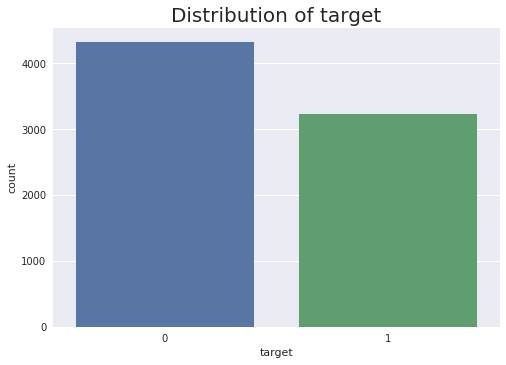

In [13]:
# Visualizing the disribution of 'target'

plt.style.use('seaborn')
sns.countplot(train['target'])
plt.title('Distribution of target', fontsize=20)

## Data Visualization

In [14]:
# Visualizing count of each keywod

px.histogram(train, x=train['keyword'], title='Count of Keyword')

<b> Maximum words have a count greater than 30. </b>

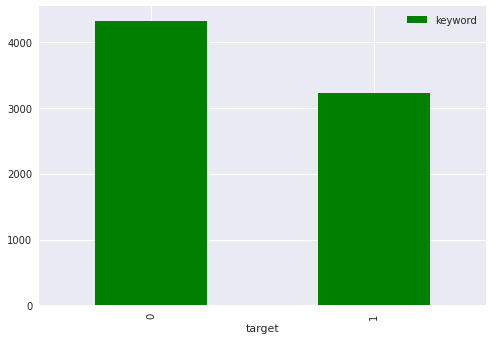

In [15]:
# Group by target and print count of keyword

a = train.groupby('target').agg({'keyword':'count'})
a.plot(kind='bar', color='green')
plt.legend()

<b> More than 3000 keywords are for disaster tweets and more than 4000 are for non-disaster tweets. </b>

## Text Preprocessing

In [16]:
# Expanding contractions

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in train, test
train['text'] = train['text'].apply(lambda x:expand_contractions(x))

In [17]:
# Cleaning text

def clean_text(text):
    text = text.lower()                                  # lower-case all characters
    text =  re.sub(r'@\S+', '',text)                     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)                  # remove urls
    text =  re.sub(r'pic.\S+', '',text) 
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return text

In [18]:
train['text'] = train['text'].apply(clean_text)

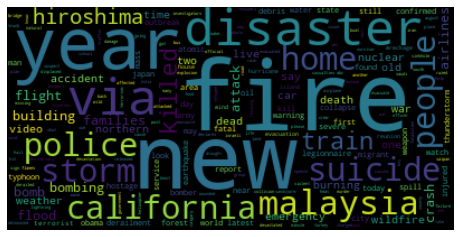

In [19]:
# Word cloud of text in disaster and non-disaster tweets

# Cleaned dataframe of disaster
df_true = train[train.target == 1]

text_true = " ".join(txt for txt in df_true['text'])

text_cloud = WordCloud(collocations=False, background_color='black').generate(text_true)
plt.axis("off")
plt.imshow(text_cloud, interpolation='bilinear')

<b> Words in disaster tweets:- </b> disaster, new, fire, via, year, suicide, police, home, dead, bombing, storm, etc.

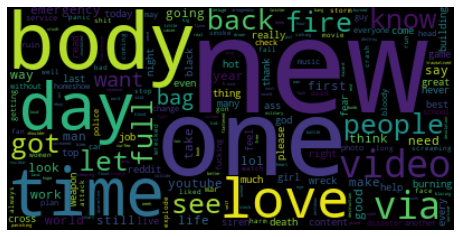

In [20]:
# Cleaned dataframe of non-disaster
df_fake = train[train.target == 0]

text_fake = " ".join(txt for txt in df_fake['text'])

text_cloud = WordCloud(collocations=False, background_color='black').generate(text_fake)
plt.axis("off")
plt.imshow(text_cloud, interpolation='bilinear')

<b> Words in non-disaster tweets:- </b> new, love, one, time, body, day, video, people, life, youtube, lol, etc.

In [21]:
# Splitting independent and dependent variables

X = train['text']
y = train['target']

In [22]:
# Splitting the dataset into train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Convert sentences to sequences

vocab_size = 1500
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

In [24]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [25]:
max_length = 120

X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='pre')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='pre')

In [26]:
y_train = np.array(y_train)
y_test = np.array(y_test)

## Model

In [27]:
embedding_vector_features = 40

model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=120))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [28]:
h = model.fit(X_train_padded, y_train, validation_data=(X_test_padded,y_test), epochs=30, batch_size=64)

Epoch 1/30
95/95 [==============================] - 18s 163ms/step - loss: 0.6600 - accuracy: 0.6002 - val_loss: 0.4735 - val_accuracy: 0.7948
Epoch 2/30
95/95 [==============================] - 14s 149ms/step - loss: 0.4314 - accuracy: 0.8090 - val_loss: 0.4552 - val_accuracy: 0.8008
Epoch 3/30
95/95 [==============================] - 14s 151ms/step - loss: 0.3714 - accuracy: 0.8446 - val_loss: 0.4495 - val_accuracy: 0.8001
Epoch 4/30
95/95 [==============================] - 14s 148ms/step - loss: 0.3511 - accuracy: 0.8563 - val_loss: 0.4705 - val_accuracy: 0.7975
Epoch 5/30
95/95 [==============================] - 14s 148ms/step - loss: 0.3262 - accuracy: 0.8609 - val_loss: 0.4807 - val_accuracy: 0.7929
Epoch 6/30
95/95 [==============================] - 15s 154ms/step - loss: 0.3210 - accuracy: 0.8640 - val_loss: 0.5036 - val_accuracy: 0.7915
Epoch 7/30
95/95 [==============================] - 14s 152ms/step - loss: 0.2980 - accuracy: 0.8731 - val_loss: 0.5309 - val_accuracy: 0.7889

In [29]:
model.evaluate(X_test_padded, y_test)

48/48 [==============================] - 1s 26ms/step - loss: 1.1503 - accuracy: 0.7406


[1.1502500772476196, 0.7405691742897034]

In [30]:
# Predicting on test data

y_pred = model.predict_classes(X_test_padded)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



In [31]:
# Calculating accuracy

accuracy_score(y_test,y_pred)

0.7405691594970218

In [32]:
# Classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       874
           1       0.69      0.71      0.70       637

    accuracy                           0.74      1511
   macro avg       0.73      0.74      0.74      1511
weighted avg       0.74      0.74      0.74      1511



<AxesSubplot:>

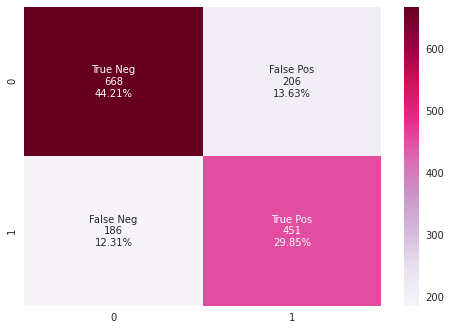

In [33]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='PuRd')

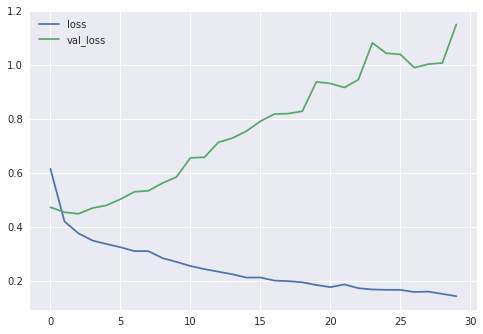

In [34]:
# Plotting loss and val_loss

plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.legend()

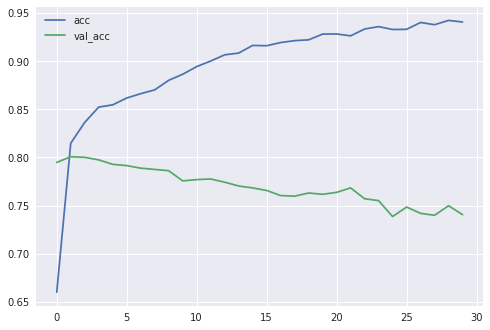

In [35]:
# Plotting accuracy and val_accuracy

plt.plot(h.history['accuracy'], label='acc')
plt.plot(h.history['val_accuracy'], label='val_acc')
plt.legend()